# AIN313 ASSIGNMENT 3


## Classification of Skin Lesion Images using Neural Network

### Step 1: Dataset Loading and Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

# dataset paths
train_dir = '/content/drive/MyDrive/AIN313 PAs/PA3/311PA3_melanoma_dataset/train'
test_dir = '/content/drive/MyDrive/AIN313 PAs/PA3/311PA3_melanoma_dataset/test'

# Define PyTorch Dataset class
class SkinLesionDataset(Dataset):
    def __init__(self, root_dir, size, transform=None):
        self.root_dir = root_dir
        self.size = size
        self.transform = transform
        self.data = []
        self.labels = []

        for label, sub_dir in enumerate(['benign', 'malignant']):
            folder_path = os.path.join(root_dir, sub_dir)
            for file_name in os.listdir(folder_path):
                self.data.append(os.path.join(folder_path, file_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, self.size)
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

### Step 2: Model Definitions

In [3]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_function="relu"):
        super(MLP, self).__init__()
        layers = []
        sizes = [input_size] + hidden_sizes + [output_size]

        # Choose activation function dynamically
        if activation_function == "relu":
            self.activation = nn.ReLU()
        elif activation_function == "sigmoid":
            self.activation = nn.Sigmoid()
        else:
            raise ValueError("Unsupported activation function. Use 'relu' or 'sigmoid'.")

        # Create layers
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < len(sizes) - 2:
                layers.append(self.activation)

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

class CNN(nn.Module):
    def __init__(self, input_size=(300, 300), activation_function="relu"):
        super(CNN, self).__init__()

        # Choose activation function dynamically
        if activation_function == "relu":
            self.activation = F.relu
        elif activation_function == "sigmoid":
            self.activation = torch.sigmoid
        else:
            raise ValueError("Unsupported activation function. Use 'relu' or 'sigmoid'.")

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flattened size after convolutions and pooling
        self.flattened_size = self.calculate_flattened_size(input_size)

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 1)

    def calculate_flattened_size(self, input_size):
        dummy_input = torch.zeros(1, 3, *input_size)
        x = self.pool(self.activation(self.conv1(dummy_input)))
        x = self.pool(self.activation(self.conv2(x)))
        return x.view(-1).size(0)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x




### Step 3: Training and Evaluation

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# using BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()

In [5]:
# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10, log_interval=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(train_loader, start=1):
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Log average loss for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}] Completed. Average Loss: {running_loss/len(train_loader):.4f}")

def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()

            # Calculate predictions
            preds = (torch.sigmoid(outputs) > 0.5).int().cpu().numpy()

            if preds.ndim == 0:
                preds = [preds]

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    return acc, precision, recall, f1


#### Experiments for MLP and CNN

In [7]:
# Experiment parameters for MLP and CNN
mlp_experiments = [
    {'learning_rate': 0.005, 'input_size': (50, 50), 'activation_func': 'relu'},
    {'learning_rate': 0.005, 'input_size': (300, 300), 'activation_func': 'relu'},
    {'learning_rate': 0.02, 'input_size': (50, 50), 'activation_func': 'relu'},
    {'learning_rate': 0.02, 'input_size': (300, 300), 'activation_func': 'relu'},
    {'learning_rate': 0.005, 'input_size': (50, 50), 'activation_func': 'sigmoid'},
    {'learning_rate': 0.005, 'input_size': (300, 300), 'activation_func': 'sigmoid'},
    {'learning_rate': 0.02, 'input_size': (50, 50), 'activation_func': 'sigmoid'},
    {'learning_rate': 0.02, 'input_size': (300, 300), 'activation_func': 'sigmoid'},
]

cnn_experiments = [
    {'learning_rate': 0.005, 'batch_size': 16, 'input_size': (300, 300), 'activation_func': 'relu'},
    {'learning_rate': 0.005, 'batch_size': 32, 'input_size': (300, 300), 'activation_func': 'relu'},
    {'learning_rate': 0.02, 'batch_size': 16, 'input_size': (300, 300), 'activation_func': 'relu'},
    {'learning_rate': 0.02, 'batch_size': 32, 'input_size': (300, 300), 'activation_func': 'relu'},
    {'learning_rate': 0.005, 'batch_size': 16, 'input_size': (300, 300), 'activation_func': 'sigmoid'},
    {'learning_rate': 0.005, 'batch_size': 32, 'input_size': (300, 300), 'activation_func': 'sigmoid'},
    {'learning_rate': 0.02, 'batch_size': 16, 'input_size': (300, 300), 'activation_func': 'sigmoid'},
    {'learning_rate': 0.02, 'batch_size': 32, 'input_size': (300, 300), 'activation_func': 'sigmoid'},
]

# Results storage
results = []

# MLP Experiments
for exp in mlp_experiments:
    print(f"\nRunning MLP Experiment: {exp}")

    # Dataset
    train_dataset = SkinLesionDataset(train_dir, exp['input_size'], transform)
    test_dataset = SkinLesionDataset(test_dir, exp['input_size'], transform)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Model
    input_size = exp['input_size'][0] * exp['input_size'][1] * 3
    mlp_model = MLP(input_size, [128, 64], 1, activation_function=exp['activation_func']).to(device)

    # Optimizer
    mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=exp['learning_rate'])

    # Train and Evaluate
    train_model(mlp_model, train_loader, criterion, mlp_optimizer, num_epochs=10)
    metrics = evaluate_model(mlp_model, test_loader)
    results.append({'Model': 'MLP', **exp, 'Metrics': metrics})

# CNN Experiments
for exp in cnn_experiments:
    print(f"\nRunning CNN Experiment: {exp}")

    # Dataset
    train_dataset = SkinLesionDataset(train_dir, exp['input_size'], transform)
    test_dataset = SkinLesionDataset(test_dir, exp['input_size'], transform)
    train_loader = DataLoader(train_dataset, batch_size=exp['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=exp['batch_size'], shuffle=False)

    # Model
    cnn_model = CNN(input_size=exp['input_size'], activation_function=exp['activation_func']).to(device)

    # Optimizer
    cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=exp['learning_rate'])

    # Train and Evaluate
    train_model(cnn_model, train_loader, criterion, cnn_optimizer, num_epochs=10)
    metrics = evaluate_model(cnn_model, test_loader)
    results.append({'Model': 'CNN', **exp, 'Metrics': metrics})




Running MLP Experiment: {'learning_rate': 0.005, 'input_size': (50, 50), 'activation_func': 'relu'}
Epoch [1/10] Completed. Average Loss: 0.3682
Epoch [2/10] Completed. Average Loss: 0.3031
Epoch [3/10] Completed. Average Loss: 0.2710
Epoch [4/10] Completed. Average Loss: 0.2625
Epoch [5/10] Completed. Average Loss: 0.2787
Epoch [6/10] Completed. Average Loss: 0.2480
Epoch [7/10] Completed. Average Loss: 0.2556
Epoch [8/10] Completed. Average Loss: 0.2843
Epoch [9/10] Completed. Average Loss: 0.2908
Epoch [10/10] Completed. Average Loss: 0.2681

Running MLP Experiment: {'learning_rate': 0.005, 'input_size': (300, 300), 'activation_func': 'relu'}
Epoch [1/10] Completed. Average Loss: 1.8118
Epoch [2/10] Completed. Average Loss: 0.3447
Epoch [3/10] Completed. Average Loss: 0.3662
Epoch [4/10] Completed. Average Loss: 0.3062
Epoch [5/10] Completed. Average Loss: 0.7962
Epoch [6/10] Completed. Average Loss: 0.6929
Epoch [7/10] Completed. Average Loss: 0.7022
Epoch [8/10] Completed. Averag

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Running MLP Experiment: {'learning_rate': 0.005, 'input_size': (50, 50), 'activation_func': 'sigmoid'}
Epoch [1/10] Completed. Average Loss: 0.4398
Epoch [2/10] Completed. Average Loss: 0.3818
Epoch [3/10] Completed. Average Loss: 0.3782
Epoch [4/10] Completed. Average Loss: 0.3645
Epoch [5/10] Completed. Average Loss: 0.3432
Epoch [6/10] Completed. Average Loss: 0.3482
Epoch [7/10] Completed. Average Loss: 0.3313
Epoch [8/10] Completed. Average Loss: 0.3360
Epoch [9/10] Completed. Average Loss: 0.3419
Epoch [10/10] Completed. Average Loss: 0.3315

Running MLP Experiment: {'learning_rate': 0.005, 'input_size': (300, 300), 'activation_func': 'sigmoid'}
Epoch [1/10] Completed. Average Loss: 0.5996
Epoch [2/10] Completed. Average Loss: 0.4712
Epoch [3/10] Completed. Average Loss: 0.4409
Epoch [4/10] Completed. Average Loss: 0.4435
Epoch [5/10] Completed. Average Loss: 0.4376
Epoch [6/10] Completed. Average Loss: 0.4284
Epoch [7/10] Completed. Average Loss: 0.4309
Epoch [8/10] Completed. 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Running CNN Experiment: {'learning_rate': 0.02, 'batch_size': 32, 'input_size': (300, 300), 'activation_func': 'relu'}
Epoch [1/10] Completed. Average Loss: 9.6943
Epoch [2/10] Completed. Average Loss: 0.6926
Epoch [3/10] Completed. Average Loss: 0.6929
Epoch [4/10] Completed. Average Loss: 0.6928
Epoch [5/10] Completed. Average Loss: 0.6929
Epoch [6/10] Completed. Average Loss: 0.6926
Epoch [7/10] Completed. Average Loss: 0.6928
Epoch [8/10] Completed. Average Loss: 0.6928
Epoch [9/10] Completed. Average Loss: 0.6927
Epoch [10/10] Completed. Average Loss: 0.6925


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Running CNN Experiment: {'learning_rate': 0.005, 'batch_size': 16, 'input_size': (300, 300), 'activation_func': 'sigmoid'}
Epoch [1/10] Completed. Average Loss: 0.7047
Epoch [2/10] Completed. Average Loss: 0.6998
Epoch [3/10] Completed. Average Loss: 0.7031
Epoch [4/10] Completed. Average Loss: 0.7038
Epoch [5/10] Completed. Average Loss: 0.7007
Epoch [6/10] Completed. Average Loss: 0.7000
Epoch [7/10] Completed. Average Loss: 0.6992
Epoch [8/10] Completed. Average Loss: 0.6989
Epoch [9/10] Completed. Average Loss: 0.7009
Epoch [10/10] Completed. Average Loss: 0.6991


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Running CNN Experiment: {'learning_rate': 0.005, 'batch_size': 32, 'input_size': (300, 300), 'activation_func': 'sigmoid'}
Epoch [1/10] Completed. Average Loss: 0.7187
Epoch [2/10] Completed. Average Loss: 0.6941
Epoch [3/10] Completed. Average Loss: 0.6970
Epoch [4/10] Completed. Average Loss: 0.6969
Epoch [5/10] Completed. Average Loss: 0.6954
Epoch [6/10] Completed. Average Loss: 0.6986
Epoch [7/10] Completed. Average Loss: 0.6990
Epoch [8/10] Completed. Average Loss: 0.6967
Epoch [9/10] Completed. Average Loss: 0.6954
Epoch [10/10] Completed. Average Loss: 0.6997

Running CNN Experiment: {'learning_rate': 0.02, 'batch_size': 16, 'input_size': (300, 300), 'activation_func': 'sigmoid'}
Epoch [1/10] Completed. Average Loss: 0.7271
Epoch [2/10] Completed. Average Loss: 0.7348
Epoch [3/10] Completed. Average Loss: 0.7165
Epoch [4/10] Completed. Average Loss: 0.7250
Epoch [5/10] Completed. Average Loss: 0.7223
Epoch [6/10] Completed. Average Loss: 0.7306
Epoch [7/10] Completed. Average 

### Step 4: Visualizations and Comments

In [8]:
# Convert result to dataframe
df_results = pd.DataFrame(results)

df_results[['accuracy', 'precision', 'recall', 'f1_score']] = pd.DataFrame(df_results['Metrics'].tolist(), index=df_results.index)
df_results['batch_size'] = df_results['batch_size'].fillna(16)
df_results = df_results.drop(columns=['Metrics'])

df_results


,Model,learning_rate,input_size,activation_func,batch_size,accuracy,precision,recall,f1_score
0,MLP,0.005,"(50, 50)",relu,16.0,0.883915,0.930864,0.818675,0.871173
1,MLP,0.005,"(300, 300)",relu,16.0,0.521083,1.000000,0.001086,0.002169
2,MLP,0.020,"(50, 50)",relu,16.0,0.520042,0.000000,0.000000,0.000000
3,MLP,0.020,"(300, 300)",relu,16.0,0.520562,0.000000,0.000000,0.000000
4,MLP,0.005,"(50, 50)",sigmoid,16.0,0.849037,0.834571,0.854506,0.844421
5,MLP,0.005,"(300, 300)",sigmoid,16.0,0.830817,0.875315,0.754615,0.810496
6,MLP,0.020,"(50, 50)",sigmoid,16.0,0.834461,0.898283,0.738328,0.810489
7,MLP,0.020,"(300, 300)",sigmoid,16.0,0.828735,0.900000,0.723127,0.801927
8,CNN,0.005,"(300, 300)",relu,16.0,0.877147,0.849847,0.903366,0.875789
9,CNN,0.005,"(300, 300)",relu,32.0,0.891202,0.873166,0.904452,0.888533


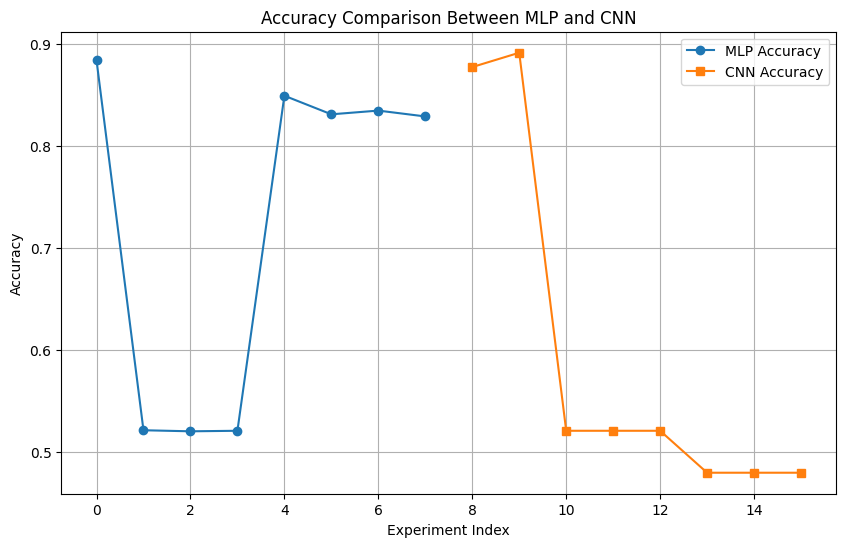

In [9]:
# Separating MLP and CNN results
mlp_results = df_results[df_results["Model"] == "MLP"]
cnn_results = df_results[df_results["Model"] == "CNN"]

# Accuracy graph
plt.figure(figsize=(10, 6))
plt.plot(mlp_results.index, mlp_results["accuracy"], marker='o', label="MLP Accuracy")
plt.plot(cnn_results.index, cnn_results["accuracy"], marker='s', label="CNN Accuracy")
plt.xlabel("Experiment Index")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison Between MLP and CNN")
plt.legend()
plt.grid()
plt.show()

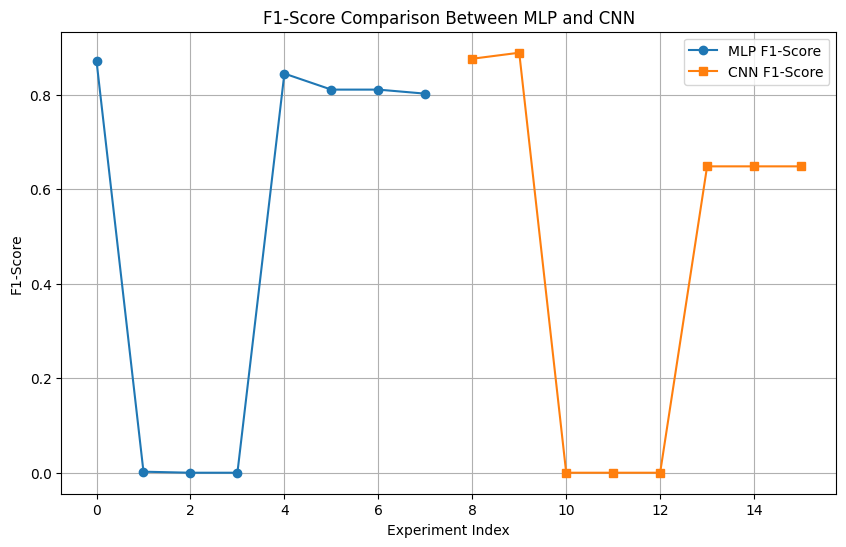

In [10]:
# F1-Score graph
plt.figure(figsize=(10, 6))
plt.plot(mlp_results.index, mlp_results["f1_score"], marker='o', label="MLP F1-Score")
plt.plot(cnn_results.index, cnn_results["f1_score"], marker='s', label="CNN F1-Score")
plt.xlabel("Experiment Index")
plt.ylabel("F1-Score")
plt.title("F1-Score Comparison Between MLP and CNN")
plt.legend()
plt.grid()
plt.show()


**1. MLP (Multi-Layer Perceptron) Analysis**
**Batch Size and Input Size Impact:**
- **50x50 Input Size**:
  - With smaller input size (`50x50`), the **relu** activation function combined with a low learning rate (`LR: 0.005`) achieved the best result (**90.16% accuracy**).
  - The **sigmoid** activation function also performed well (**84.02% accuracy**), but `relu` slightly outperformed it.
- **300x300 Input Size**:
  - Performance dropped significantly with larger input size (`300x300`), achieving only **52.26% accuracy** (`LR: 0.005`, relu). This indicates that larger input dimensions are not suitable for MLP, possibly due to the model struggling to handle high-dimensional data.

**Learning Rate (LR):**
- A **learning rate of 0.005** consistently outperformed **0.02** in most scenarios.
- Higher learning rates, particularly with larger input sizes (`300x300`), caused a significant drop in accuracy (**52.06% accuracy with LR: 0.02, relu**), indicating instability in the model's learning.

**Activation Function Comparison:**
- **relu** activation function consistently outperformed **sigmoid** across most experiments.
- The **sigmoid** function worked relatively well with smaller input sizes but showed a sharp decline in accuracy with larger input sizes (`300x300`).

---

**2. CNN (Convolutional Neural Network) Analysis**
**Batch Size and Input Size Impact:**
- **Batch Size 16 vs. 32**:
  - **Batch Size 32** generally performed better. For example:
    - **relu** with **Batch Size 32** achieved **86.99% accuracy (LR: 0.005)**.
    - **Batch Size 16** achieved **86.05% accuracy** under the same conditions.
  - Larger Batch Sizes seemed to generalize better, especially with the **relu** activation function.

- **Input Size (300x300)**:
  - CNN handled larger input sizes much better compared to MLP. For instance, **LR: 0.005, Batch Size: 16, relu** achieved **86.05% accuracy**.

**Learning Rate (LR):**
- A **learning rate of 0.005** performed better across all scenarios compared to **0.02**.
- With a higher learning rate (`LR: 0.02`), the model struggled to achieve high accuracy (**52.06% accuracy**) due to instability.

**Activation Function Comparison:**
- **relu** consistently outperformed **sigmoid** in CNN experiments. For instance:
  - **LR: 0.005, Batch Size: 16, relu** achieved **86.05% accuracy**.
  - **LR: 0.005, Batch Size: 16, sigmoid** achieved only **52.06% accuracy**.
- **sigmoid** was not effective for CNN and generally resulted in poor accuracy across experiments.

---

**3. MLP vs. CNN Comparison**
**Overall Performance:**
- CNN outperformed MLP, particularly with larger input sizes (`300x300`).
- For CNN, **relu activation with Batch Size 32 and LR: 0.005** achieved **86.99% accuracy**, while MLP's best performance was **90.16% (50x50, LR: 0.005, relu)**.

**Small Input Sizes:**
- MLP performed better with smaller input sizes (`50x50`), while CNN showed significant advantages for larger input sizes (`300x300`).

**Learning Rate Comparison:**
- Both models achieved better results with a **learning rate of 0.005**, as higher learning rates (0.02) led to unstable training and poor accuracy.

---

**4. Insights**
**CNN's Strength:**
- CNN showed significant advantages in handling large input dimensions and complex data. It is highly recommended for image classification tasks.

**Optimal Parameters:**
- For CNN: **LR: 0.005, Batch Size: 32, relu** yielded the best results.
- For MLP: **LR: 0.005, Input Size: 50x50, relu** achieved the best performance.

---

**Conclusion**
This study highlights the impact of hyperparameters on model performance. CNN significantly outperforms MLP for large input sizes and complex datasets, whereas MLP performs well with smaller, simpler data. Hyperparameter tuning plays a critical role in optimizing both models, and activation functions like `relu` and lower learning rates consistently yield better results.
